# Unsupervised Classification

## Load imports.

In [2]:
# Make common scripts visible and unsupervised classifier code
import sys
sys.path.append('../common/')
sys.path.append('../kb-classifier/')

import numpy as np
import nltk
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

from reuters_parser import load_data
from lookup_tables import topic_code_to_topic_dict, topic_code_to_int, int_to_topic_code
from sentence_utils import remove_stop_words_and_lemmatize
from conversion import convert_dictionary_to_array
from kb_classifier import KnowledgeBasePredictor
from kb_common import int_to_topic

## Load the data.

In [3]:
def sanitise_each_topic(text):      
    return remove_stop_words_and_lemmatize(text, lowercase=False, lemmatize=False, keep_nouns_only=True)


#year_data = load_data('19960820', '19970819', '../../../downloads/reuters/rcv1/', topic_code_to_topic_dict)
year_data = load_data('19960820', '19960830', '../../../downloads/reuters/rcv1/', topic_code_to_topic_dict)

# For accurate comparison with the Naive Bayes classifier, keep the last 20% of documents using the same random seed.
# I.e. we are making predictions on the same test set.
np.random.seed(42)

# Get 20% test
x, y = convert_dictionary_to_array(year_data, topic_code_to_int)
total_examples = len(y)
split_point = int(total_examples * 0.8)
test_x = np.array(list(map(sanitise_each_topic, x[split_point:])))
test_y = y[split_point:]


# Take 20 documents of each type from the training set for classifier tuning
train_x = []
train_y = np.zeros(shape=120)

counts = np.zeros(shape=len(topic_code_to_int.keys()))
current_index = 0
print(split_point)
for i in range(split_point):
    topic_int = y[i]
    
    if counts[topic_int] < 20:
        train_x.append(x[i])
        train_y[current_index] = topic_int
        counts[topic_int] += 1
        current_index += 1

train_x = np.array(list(map(sanitise_each_topic, train_x)))
print(counts)

2130
[20. 20. 20. 20. 20. 20.]


## Initialise and tune class probabilities for unsupervised learner

In [4]:
np.random.seed(42)
kb_predictor = KnowledgeBasePredictor(topic_code_to_topic_dict.values(), topic_depth=0)
kb_predictor.train(train_x, train_y)

Wiki topic probabilies shape: (120, 11)


In [5]:
predict_y = kb_predictor.predict(train_x)
classification_report, confusion_matrix = kb_predictor.get_classification_report(train_y, predict_y)

print(classification_report)
print(confusion_matrix)

Wiki topic probabilies shape: (120, 11)
                        precision    recall  f1-score   support

CRIME, LAW ENFORCEMENT   1.000000  1.000000  1.000000        20
  ECONOMIC PERFORMANCE   1.000000  1.000000  1.000000        20
             ELECTIONS   1.000000  1.000000  1.000000        20
                HEALTH   1.000000  1.000000  1.000000        20
              RELIGION   1.000000  1.000000  1.000000        20
                SPORTS   1.000000  1.000000  1.000000        20

             micro avg   1.000000  1.000000  1.000000       120
             macro avg   1.000000  1.000000  1.000000       120
          weighted avg   1.000000  1.000000  1.000000       120

[[20  0  0  0  0  0]
 [ 0 20  0  0  0  0]
 [ 0  0 20  0  0  0]
 [ 0  0  0 20  0  0]
 [ 0  0  0  0 20  0]
 [ 0  0  0  0  0 20]]


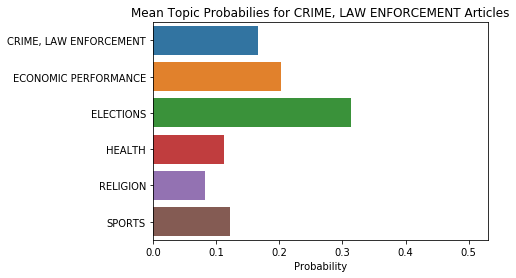

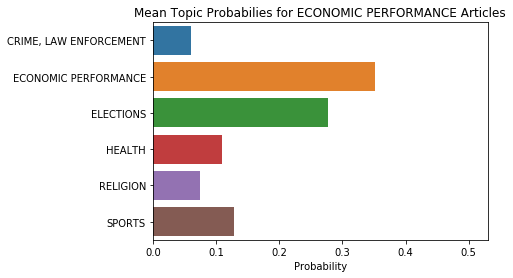

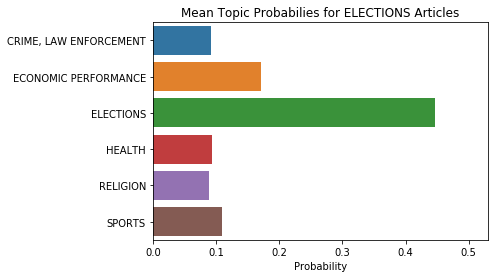

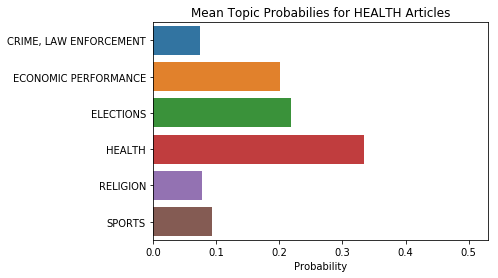

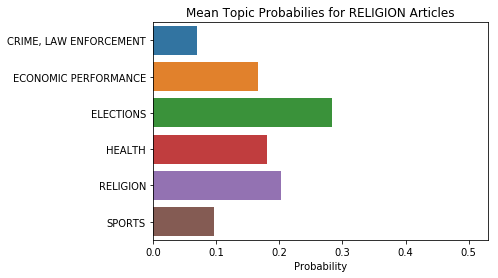

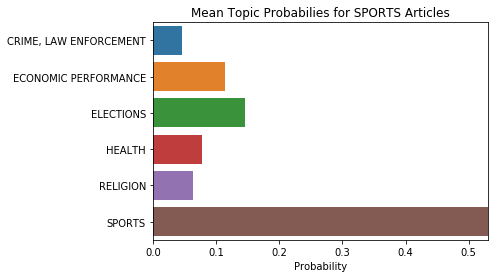

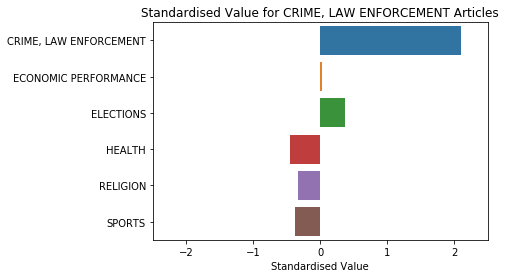

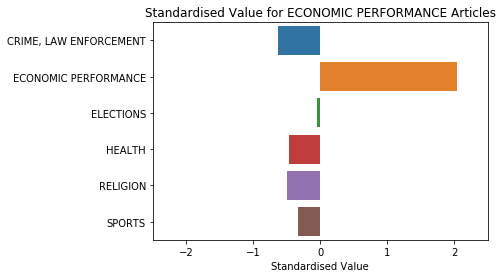

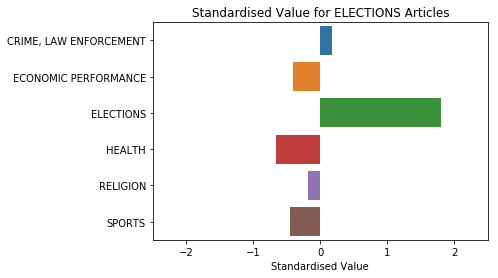

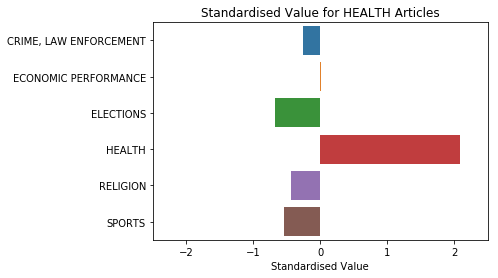

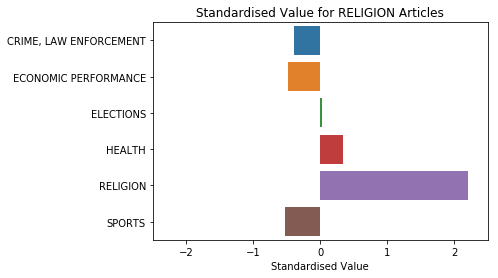

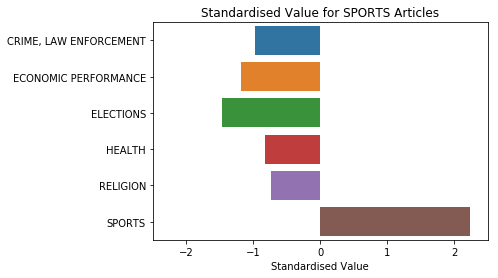

In [6]:
prob_means = np.zeros(shape=(6, 6))

# Plot graph of mean topic probabilities for each topic class
for index, topic_code in int_to_topic_code.items():
    prob_mean = np.mean(kb_predictor.last_class_probabilities[train_y == index], axis=0)
    prob_std = np.std(kb_predictor.last_class_probabilities[train_y == index], axis=0)
    prob_means[index] = prob_mean
    
    plt.figure()
    plt.title('Mean Topic Probabilies for {} Articles'.format(topic_code_to_topic_dict[topic_code]))
    plt.xlabel('Probability')
    plt.xlim(0.0, 0.53)
    sns.barplot(x=prob_mean, y=list(int_to_topic.values()))
    plt.savefig('topic_prob_{}.pdf'.format(topic_code_to_topic_dict[topic_code]), bbox_inches='tight')
    plt.show()
    
# Plot graph of mean topic probabilities for each topic class
for index, topic_code in int_to_topic_code.items():
    prob_mean = np.mean(kb_predictor.last_class_probabilities[train_y == index], axis=0)
    prob_std = np.std(kb_predictor.last_class_probabilities[train_y == index], axis=0)
    
    plt.figure()
    plt.title('Standardised Value for {} Articles'.format(topic_code_to_topic_dict[topic_code]))
    plt.xlabel('Standardised Value')
    plt.xlim(-2.5, 2.5)
    sns.barplot(x=((prob_mean-np.mean(prob_means, axis=0))/np.std(prob_means, axis=0)),
                   y=list(int_to_topic.values()))
    plt.savefig('standardised_{}.pdf'.format(topic_code_to_topic_dict[topic_code]), bbox_inches='tight')
    plt.show()

## Assess unsupervised classifier performance.

In [ ]:
print('Making predictions for {} documents'.format(len(test_y)))
predict_y = kb_predictor.predict(test_x)
classification_report, confusion_matrix = kb_predictor.get_classification_report(test_y, predict_y)

print(classification_report)
print(confusion_matrix)

Making predictions for 533 documents


## Find examples where predictions went wrong

In [38]:
for topic_code, index in topic_code_to_int.items():
    topic_subset = predict_y[test_y == index]
    topic_subset_incorrect = topic_subset[topic_subset != index]
    document_subset = test_x[test_y == index]
    document_subset = document_subset[topic_subset != index]
    
    print('------ 5 random erroneous predictions for {} ------'.format(topic_code_to_topic_dict[topic_code]))
    print('')
    random_indices = np.random.choice(np.arange(len(topic_subset_incorrect)), 5)
    for index in random_indices:
        print(document_subset[index])
        print('')
        print('Above classified as {}'.format(topic_code_to_topic_dict[int_to_topic_code[topic_subset_incorrect[index]]]))
        print('')
    print('')

------ 5 random erroneous predictions for CRIME, LAW ENFORCEMENT ------

Mexico foreign minister Friday country response corruption charges top drug enforcement official U.S. policy country anti-narcotics effort reason drugs grade certification anybody Mexican_Foreign_Minister_Jose_Angel_Gurria news conference fact inhibits cooperation Mexico countries U.S. certification end month Washington annual evaluation governments actions drug traffickings test U.S. economic trade sanctions Gurria Washington meetings White_House State_Department Justice_Department international fallout Tuesday announcement Mexican anti-drug chief Gen._Jesus_Gutierrez_Rebollo post drug corruption White_House spokesman Mike_McCurry Gurria several pieces mind Gutierrez matter Gurria presidential adviser Thomas Mack McLarty Thursday Friday spokesman Senate_Foreign_Relations_Committee Mexico certification Mexico short decertifications countries serious spokesman Mark_Thiessen telephone interview President_Bill_Clinto

------ 5 random erroneous predictions for ELECTIONS ------

bill Brazilian President_Fernando_Henrique_Cardoso re-election next year due second final vote Senate later Wednesday official vote place afternoon local time/1600 EDT/2000_GMT official spokesman Senate possibility left-wing opposition parties high court injunction vote parties Supreme_Federal_Tribunal_Tuesday vote investigations allegations members Chamber Deputies re-election bill injunction everything normal spokesman constitutional amendment three-fifths majority equivalent Senate members first vote May senators favor bill today scheduled vote bill symbolic confirmation joint session Congress law state governors city mayors second consecutive term William_Schomberg Brasilia newsroom

Above classified as CRIME, LAW ENFORCEMENT

Moslem members families children attack young girls Algerian newspapers Saturday El_Watan people Cheraifia Boufarik region Blida province night-time raid groups dozen terrorists Al_Khabar main Arabic

------ 5 random erroneous predictions for SPORTS ------

Leicester_City football club shares stock market move value English premier league side pounds Sunday_Telegraph newspaper Leicester middle premier league table Coca_Cola_Cup final shareholders plan Victory Coca-Cola final next month first cup final years Midlands club European competition year London newsroom British Pounds

Above classified as ECONOMIC PERFORMANCE

Famed sportscaster Marv_Albert public Thursday first time woman innocent NBA playoffs innocence charges false proven false court law Albert news conference work NBA NBC_Sports MSG network innocence public courtroom brief news conference Albert lawyers due process case public Tuesday broadcaster indictment Monday Arlington Virginia 53-year-old sportscaster Arlington_Circuit_Court felony count forcible sodomy misdemeanor count assault battery alleged incident Arlington hotel room February Attorney_Gerard_Treanor Albert police prosecutors grand jury Treanor Albert court 